<a href="https://colab.research.google.com/github/abdusalam7474/Contract_review_Nig/blob/main/Politcal_Tweets_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd /content/drive/MyDrive/Political_Tweet

/content/drive/MyDrive/Political_Tweet


#Preprocessing and Training

In [ ]:
pip install keras_preprocessing

In [ ]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import pickle
import missingno as msno
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

In [ ]:
cd /content/drive/MyDrive/Political_Tweet/data/tweet_data/

/content/drive/MyDrive/Political_Tweet/data/tweet_data


##Data preprocessing

In [ ]:
ls

mlp_model.sav         RNN_model.h5           tinubu_train.xlsx
peter_train_old.xlsx  svc_model.sav          tokenizer.pickle
peter_train.xlsx      tinubu_train_old.xlsx  xgb_model.sav


In [ ]:
#df = pd.read_excel("aisha_yesufu_labour-party.xlsx", header=0)
#df2 = pd.read_excel("Asiwaju_Oladimej_peter-2.xlsx", header=0)

In [ ]:
df = pd.read_excel("peter_train.xlsx", header=0)
df2 = pd.read_excel("tinubu_train.xlsx", header=0)

In [ ]:
#df2 = df2.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7'])

In [ ]:

#Assign label columns

df['label'] = 0
df2['label'] = 1

In [ ]:

#drop date column

df = df.drop(columns=['date'])
df2 = df2.drop(columns=['date'])

In [ ]:
df.head()

,tweet,label
0,Obi,0
1,Peter Obi voted,0
2,Obi,0
3,I wish Obi the best,0
4,"But the spokesman for the DSS, Dr. Peter Afuna...",0


In [ ]:
df2.head()

,tweet,label
0,""".......I left the UK in 2025......""\n\nPeter Obi",1
1,"Once Obi starts answering a question with ""THA...",1
2,LP submitted Party Membership Register to INEC...,1
3,AriseTv: Did you leak that conversation betwee...,1
4,Obi’s legacy......\n\nSAY NO TO IPOB TERRORIST...,1


In [ ]:
print(len(df))
print(len(df2))

1390
1107


In [ ]:
df_3 = df[:1107]

In [ ]:

#join the two dataframe

#train = pd.concat([df,df2],axis=0, ignore_index=True)
train = pd.concat([df_3,df2],axis=0, ignore_index=True)
len(train)

2214

<Axes: >

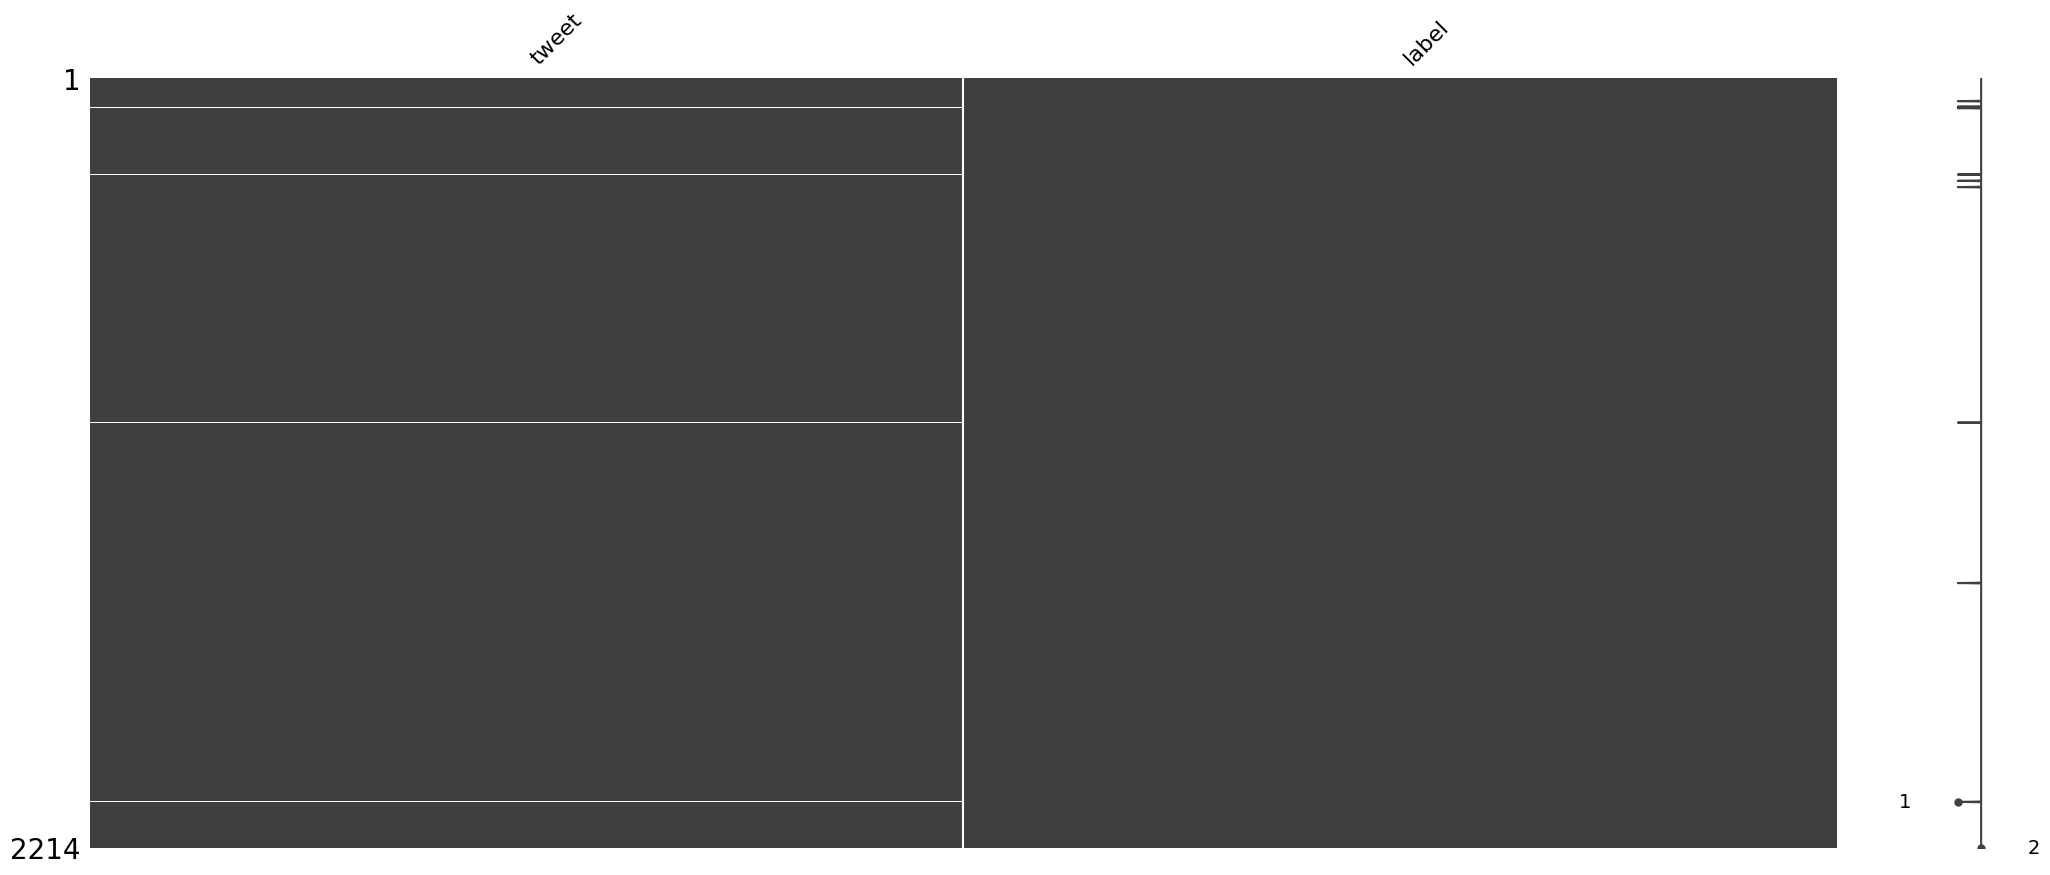

In [ ]:
#visualize missing values

msno.matrix(train)

In [ ]:
missing_values = train.isna().sum()
missing_values.sum()

10

In [ ]:

#Drop empty values
train.dropna(inplace=True)
len(train)

2204

In [ ]:
features = train['tweet']
labels = train['label']

print(len(features))
print(len(labels))

2204
2204


Data cleaning

In [ ]:

#removing links using regular expression


# regular expression pattern to match URLs
url_pattern = re.compile(r'https?://\S+')

# remove URLs from 'text' column using regular expressions
features = features.apply(lambda x: url_pattern.sub('', x))

In [ ]:
#Removing stopwords

import nltk
nltk.download('stopwords') # download the stopwords list
from nltk.corpus import stopwords

# define a set of stopwords to remove
stop_words = set(stopwords.words('english'))

# tokenize the tweet text and remove stopwords
features = features.apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

print(features[:10])

0                                                  Obi
1                                      Peter Obi voted
2                                                  Obi
3                                        wish Obi best
4    spokesman DSS, Dr. Peter Afunanya, could immed...
5                                        Tell love Obi
6    Fake news Rufai Dancing LP Lagos debunked.Chec...
7           condemn attacks LP supporters Lagos today.
8    people sharing pictures Peter Obi prove point,...
9                           Obi overtakes Tinubu Lagos
Name: tweet, dtype: object


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Removing puctuations and special characheters

# Define regular expression pattern to match new line characters and other special characters
pattern = r"[\n#.?,()!~$%./_-]"

# Remove new line characters and other special characters from tweet column
features = features.apply(lambda x: re.sub(pattern, '', x))

# Print resulting dataframe
print(features)

0                                                     Obi
1                                         Peter Obi voted
2                                                     Obi
3                                           wish Obi best
4       spokesman DSS Dr Peter Afunanya could immediat...
                              ...                        
2209                                      Tinubu good man
2210                                             Obi liar
2211                                              Obi lie
2212                                          Obi bad man
2213                             Tinubu president Nigeria
Name: tweet, Length: 2204, dtype: object


word cloud

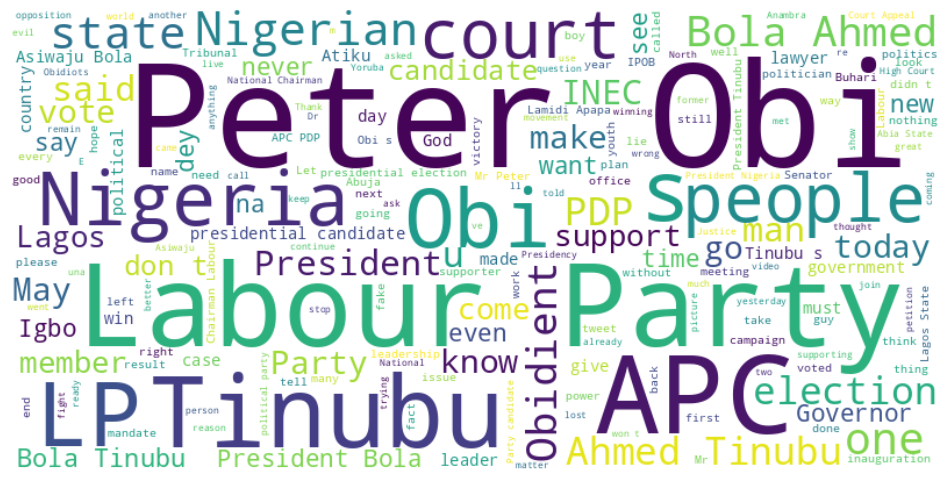

In [ ]:

# combine all tweet text into a single string
all_text = ' '.join(features)

# create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# plot the word cloud
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
features[44]

'condemn attacks LP supporters Lagos today'

vocabularies

In [ ]:
#-Extracting Vocabs
words = []
for feature in features:
    text = feature.split(" ")
    for item in text:
       if item not in words:
          words.append(item)
vocab_size = len(words)
print(vocab_size)

9420


Further preprocessing

In [ ]:
print(words[:10])

['Obi', 'Peter', 'voted', 'wish', 'best', 'spokesman', 'DSS', 'Dr', 'Afunanya', 'could']


In [ ]:

# create a tokenizer object
tokenizer = Tokenizer()

# fit the tokenizer on the documents
tokenizer.fit_on_texts(features)

# convert the documents to integer sequences
features_seq = tokenizer.texts_to_sequences(features)

In [ ]:


# saving tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:

max_length = 0
for item in features_seq:
   lent = len(item)
   if lent > max_length:
      max_length = lent

print(max_length)

46


In [ ]:

# Pad the input data with zeros

padded_features = pad_sequences(features_seq, maxlen=max_length, padding='post', value=0)

In [ ]:
padded_features[1]

array([  2,   1, 106,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [ ]:
#Train test split

X_train, X_test, y_train, y_test = train_test_split(padded_features, labels, test_size=0.2, shuffle=True, random_state=42)

In [ ]:

# print the shapes of the resulting data sets
print('X_train data shape:', X_train.shape)
print('X_test data shape:', X_test.shape)
print('y_train data shape:', y_train.shape)
print('y_test data shape:', y_test.shape)

X_train data shape: (1763, 46)
X_test data shape: (441, 46)
y_train data shape: (1763,)
y_test data shape: (441,)


##Model

LSTM model

In [ ]:

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
model.add(LSTM(units=64, return_sequences=True))
model.add(layers.Dropout(0.5))
model.add(LSTM(units=32))
model.add(layers.Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 46, 128)           1205760   
                                                                 
 lstm_24 (LSTM)              (None, 46, 64)            49408     
                                                                 
 dropout_24 (Dropout)        (None, 46, 64)            0         
                                                                 
 lstm_25 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_25 (Dropout)        (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,267,617
Trainable params: 1,267,617
N

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/50
56/56 [==============================] - 11s 95ms/step - loss: 0.6956 - accuracy: 0.4861 - val_loss: 0.6914 - val_accuracy: 0.5669
Epoch 2/50
56/56 [==============================] - 5s 94ms/step - loss: 0.6275 - accuracy: 0.6557 - val_loss: 0.5839 - val_accuracy: 0.6712
Epoch 3/50
56/56 [==============================] - 5s 95ms/step - loss: 0.3872 - accuracy: 0.8622 - val_loss: 0.5940 - val_accuracy: 0.7778
Epoch 4/50
56/56 [==============================] - 4s 78ms/step - loss: 0.2662 - accuracy: 0.9121 - val_loss: 0.5722 - val_accuracy: 0.7959
Epoch 5/50
56/56 [==============================] - 6s 101ms/step - loss: 0.1455 - accuracy: 0.9575 - val_loss: 0.7130 - val_accuracy: 0.7778
Epoch 6/50
56/56 [==============================] - 5s 88ms/step - loss: 0.1312 - accuracy: 0.9699 - val_loss: 0.8500 - val_accuracy: 0.7755
Epoch 7/50
56/56 [==============================] - 4s 78ms/step - loss: 0.1172 - accuracy: 0.9756 - val_loss: 0.9068 - val_accuracy: 0.7642
Epoch 8/50


In [ ]:

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

14/14 [==============================] - 1s 47ms/step - loss: 0.9567 - accuracy: 0.8073
Test Loss: 0.9567104578018188
Test Accuracy: 0.8072562217712402


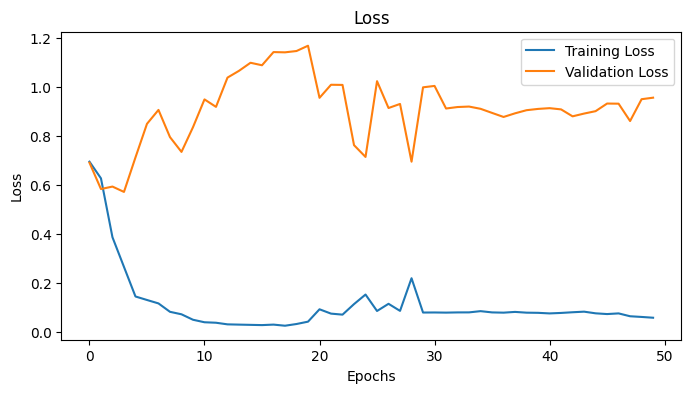

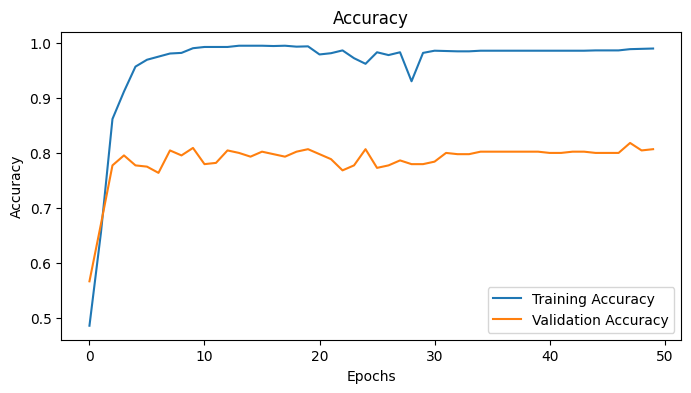

In [ ]:
import matplotlib.pyplot as plt

# Get the training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(8, 4))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

14/14 [==============================] - 1s 16ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_classes))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       221
           1       0.84      0.75      0.80       220

    accuracy                           0.81       441
   macro avg       0.81      0.81      0.81       441
weighted avg       0.81      0.81      0.81       441



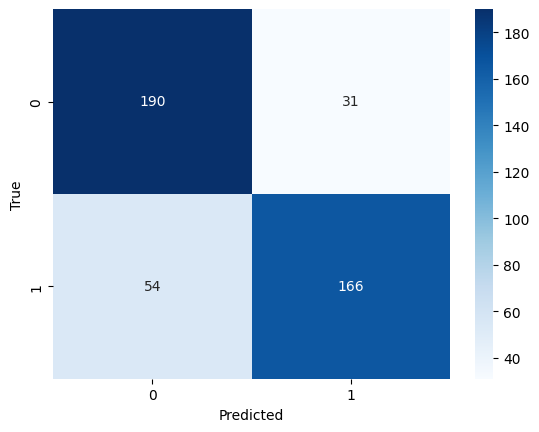

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_classes)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
model.save("RNN_model.h5")

Machine learnin Model Evaluation

SVC

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
parameters={'C':[1,2000],'kernel':['rbf','sigmoid']}
svc = SVC()
clf=GridSearchCV(svc,parameters)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Best Accuracy:",accuracy_score(y_test, y_pred))
print("Best Parameters:",clf.best_params_)

Best Accuracy: 0.7710843373493976
Best Parameters: {'C': 1, 'kernel': 'rbf'}


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.91      0.82       280
           1       0.83      0.60      0.70       218

    accuracy                           0.77       498
   macro avg       0.79      0.75      0.76       498
weighted avg       0.78      0.77      0.76       498



In [ ]:
# save the model to disk
filename = 'svc_model.sav'
pickle.dump(clf, open(filename, 'wb'))

MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
parameters={
    'hidden_layer_sizes':[(320),(320,160),(320,160,80,40)],
    'activation':['logistic','tanh','relu']
}
mlp = MLPClassifier()
clf=GridSearchCV(mlp,parameters)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Best Accuracy:",accuracy_score(y_test, y_pred))
print("Best Parameters:",clf.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Best Accuracy: 0.6077097505668935
Best Parameters: {'activation': 'logistic', 'hidden_layer_sizes': (320, 160)}


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.62      0.58      0.60       221
           1       0.60      0.64      0.62       220

    accuracy                           0.61       441
   macro avg       0.61      0.61      0.61       441
weighted avg       0.61      0.61      0.61       441



In [ ]:

# save the model to disk
filename = 'mlp_model.sav'
pickle.dump(clf, open(filename, 'wb'))

XG Boost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
parameters={
    'max_depth':[3,5,7],
    'learning_rate':[0.1,0.5,0.9],
    'n_estimators':[100,500,1000]
}
xgb = XGBClassifier()
clf=GridSearchCV(xgb,parameters)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Best Accuracy:",accuracy_score(y_test, y_pred))
print("Best Parameters:",clf.best_params_)

Best Accuracy: 0.9056224899598394
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.98      0.91       221
           1       0.98      0.81      0.89       220

    accuracy                           0.90       441
   macro avg       0.91      0.90      0.90       441
weighted avg       0.91      0.90      0.90       441



In [ ]:
# save the model to disk
filename = 'xgb_model.sav'
pickle.dump(clf, open(filename, 'wb'))

##Bert model

In [ ]:
pip install transformers

In [ ]:
dfb = train

In [ ]:
dfb.head()

,tweet,label
0,Obi,0
1,Peter Obi voted,0
2,Obi,0
3,I wish Obi the best,0
4,"But the spokesman for the DSS, Dr. Peter Afuna...",0


In [ ]:
import torch
from tqdm import tqdm

In [ ]:
dfb['data_type'] = ['not_set'] * dfb.shape[0]

In [ ]:
from sklearn.model_selection import train_test_split

#train test split
X_train, X_val, y_train, y_val = train_test_split(dfb.index.values,
                                                   dfb.label.values,
                                                   test_size = 0.2,
                                                   random_state = 17,
                                                   stratify = dfb.label.values
                                                  )

In [ ]:
dfb.loc[X_train, 'data_type'] = 'train'
dfb.loc[X_val, 'data_type'] = 'val'

#groupby count
dfb.groupby(['label', 'data_type']).count()

tweet
label data_type       
0     train        879
      val          220
1     train        884
      val          221

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                         do_lower_case = True)

In [ ]:
#encode train set
encoded_data_train = tokenizer.batch_encode_plus(dfb[dfb.data_type == 'train'].tweet.values,
                                                add_special_tokes = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 256,
                                                return_tensors = 'pt')

#encode validation set
encoded_data_val = tokenizer.batch_encode_plus(dfb[dfb.data_type == 'val'].tweet.values,
                                                add_special_tokes = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 256,
                                                return_tensors = 'pt')

Keyword arguments {'add_special_tokes': True} not recognized.
Keyword arguments {'add_special_tokes': True} not recognized.
Keyword arguments {'add_special_tokes': True} not recognized.
Keyword arguments {'add_special_tokes': True} not recognized.
Keyword arguments {'add_special_tokes': True} not recognized.
Keyword arguments {'add_special_tokes': True} not recognized.
Keyword arguments {'add_special_tokes': True} not recognized.
Keyword arguments {'add_special_tokes': True} not recognized.
Keyword arguments {'add_special_tokes': True} not recognized.
Keyword arguments {'add_special_tokes': True} not recognized.
Keyword arguments {'add_special_tokes': True} not recognized.
Keyword arguments {'add_special_tokes': True} not recognized.
Keyword arguments {'add_special_tokes': True} not recognized.
Keyword arguments {'add_special_tokes': True} not recognized.
Keyword arguments {'add_special_tokes': True} not recognized.
Keyword arguments {'add_special_tokes': True} not recognized.
Keyword 

In [ ]:
#train set
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(dfb[dfb.data_type == 'train'].label.values)

#validation set
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(dfb[dfb.data_type == 'val'].label.values)

In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = 2,
                                                      output_attentions = False,
                                                      output_hidden_states = False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.31.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
model.cuda()

In [ ]:
from torch.utils.data import TensorDataset

#train set
dataset_train = TensorDataset(input_ids_train,
                              attention_masks_train,
                              labels_train)

#validation set
dataset_val = TensorDataset(input_ids_val,
                             attention_masks_val,
                             labels_val)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

#train set
dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size)

#validation set
dataloader_val = DataLoader(dataset_val,
                              sampler = RandomSampler(dataset_val),
                              batch_size = 32) #since we don't have to do backpropagation for this step

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                 lr = 1e-5,
                 eps = 1e-8) #2e-5 > 5e-5

epochs = 10

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = len(dataloader_train)*epochs)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def evaluate(dataloader_val):

    #evaluation mode
    model.eval()

    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in tqdm(dataloader_val):

        #load into GPU
        batch = tuple(b.to(device) for b in batch)

        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():
            outputs = model(**inputs)

        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds, average = 'weighted')

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

def f1_score_func_x(preds, labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    print(labels_flat)
    print(preds_flat)
    return f1_score(labels_flat, preds) #average = 'weighted')

In [ ]:
#accuracy score
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    #make prediction
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:

torch.cuda.is_available()

True

In [ ]:

device = "cuda"
for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train,
                        desc = 'Epoch {:1d}'.format(epoch),
                        leave = False,
                        disable = False)

    for batch in progress_bar:

        model.zero_grad() #set gradient to 0

        batch = tuple(b.to("cuda") for b in batch)

        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        outputs = model(**inputs) #unpack the dict straight into inputs

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})

    torch.save(model.state_dict(), f'/content/Model/ BERT_ft_epoch{epoch}.model')

    tqdm.write('\n Epoch {epoch}')

    loss_train_ave = loss_train_total / len(dataloader_train)
    tqdm.write('Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

  0%|          | 0/10 [01:15<?, ?it/s]


 Epoch {epoch}
Training loss: {loss_train_avg}



  0%|          | 0/10 [01:22<?, ?it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-37-1eb569b72dab>", line 43, in <cell line: 2>
    val_f1 = f1_score_func(predictions, true_vals)
  File "<ipython-input-32-a1f9e8b770d9>", line 7, in f1_score_func
    return f1_score(labels_flat, preds, average = 'weighted')
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1573, in precision_recall_fscore_support
    labels = _check_set_wise_labels(y_true, y_pred, average, labels, pos_label)
  File "/usr/local/lib/python3.10/dist-packages/skle

#Testing

In [ ]:
cd /content/drive/MyDrive/Political_Tweet/models

/content/drive/MyDrive/Political_Tweet/models


In [ ]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import pickle
import missingno as msno
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

In [ ]:
pip install keras_preprocessing

In [ ]:
import os
from keras.models import load_model
import nltk
nltk.download('stopwords') # download the stopwords list
from nltk.corpus import stopwords
import pandas as pd
import re
import pickle
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
#os.mkdir("models")

# define a set of stopwords to remove
stop_words = set(stopwords.words('english'))
# Define regular expression pattern to match new line characters and other special characters
pattern = r"[\n#.?,()!~$%./_-]|[^a-zA-Z0-9\s]"

# regular expression pattern to match URLs
url_pattern = re.compile(r'https?://\S+|www\.\S+')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# loading tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
# load the model from disk
svc_model = pickle.load(open("svc_model.sav", 'rb'))
mlp_model = pickle.load(open("mlp_model.sav", 'rb'))
xgb_model = pickle.load(open("xgb_model.sav", 'rb'))
rnn_model = load_model("RNN_model.h5")

In [ ]:

def tweet_preproc(tweet):
    max_length = 46
    features = tweet
    features = pd.Series(features) # convert string to Series
    features = features.apply(lambda x: url_pattern.sub('', x))
    features = features.apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
    features = features.apply(lambda x: re.sub(pattern, '', x))

    # convert the documents to integer sequences
    features_seq = tokenizer.texts_to_sequences(features)
    # Pad the input data with zeros
    padded_features = pad_sequences(features_seq, maxlen=max_length, padding='post', value=0)

    return padded_features

In [ ]:

def pred_tweet(text, model_name):
  if model_name == "rnn":
     model = rnn_model
     tweet_tok = tweet_preproc(text)
     pred = model.predict(tweet_tok)
     if pred > 0.5:
         tweet_sent = "Tweet favours Bola Ahmed Tinubu"
         conf = (100*((pred[0]-0.5)/0.5))[0]
     if pred < 0.5:
         tweet_sent = "Tweet favours Peter obi"
         conf = (100*((0.5-pred[0])/0.5))[0]
  if model_name == "svc":
     model = svc_model
     tweet_tok = tweet_preproc(text)
     pred = model.predict(tweet_tok)
     probs = (model.predict_proba(tweet_tok))
     if pred > 0.5:
         tweet_sent = "Tweet favours Bola Ahmed Tinubu"
         conf = probs[0][1]
     if pred < 0.5:
         tweet_sent = "Tweet favours Peter obi"
         conf = probs[0][0]
  if model_name == "mlp":
     model = mlp_model
     tweet_tok = tweet_preproc(text)
     pred = model.predict(tweet_tok)
     probs = (model.predict_proba(tweet_tok))
     if pred > 0.5:
         tweet_sent = "Tweet favours Bola Ahmed Tinubu"
         conf = probs[0][1]
     if pred < 0.5:
         tweet_sent = "Tweet favours Peter obi"
         conf = probs[0][0]
  if model_name == "xgb":
     model = xgb_model
     tweet_tok = tweet_preproc(text)
     pred = model.predict(tweet_tok)
     probs = (model.predict_proba(tweet_tok))
     if pred > 0.5:
         tweet_sent = "Tweet favours Bola Ahmed Tinubu"
         conf = probs[0][1]
     if pred < 0.5:
         tweet_sent = "Tweet favours Peter obi"
         conf = probs[0][1]

  return tweet_sent, conf

In [ ]:
pred_tweet(text="condemn attacks LP supporters Lagos today", model_name="xgb")

('Tweet favours Peter obi', 0.35206553)

In [ ]:

def pred_tweets(tweet_list, model):
  tweets_sent_dic = []
  avrg_tweet_sent = []
  for tweet in tweet_list:
    tweet_sent, prediction = pred_tweet(tweet)
    dic = [tweet:'tweet_sent']
    tweets_sent_dic.append(dic)
    avrg_tweet_sent.append(prediction)
  avrg_tweet_sent = avrg(avrg_tweet_sent)
  return tweets_sent_dic, avrg_tweet_sent

In [ ]:
test = "The Lamidi Apapa faction of Labour Party on Friday told the presidential candidate of the party, Peter Obi, to step down his case at the Presidential Election Petitions Tribunal over what they described as lack of seriousness According to the faction, the advice became"

In [ ]:
test = "The Presidential Election Petition Court, PEPC, sitting in Abuja, on Saturday, struck out an application the candidate of the Labour Party, LP, Mr Peter Obi, filed for permission to interrogate the Independent National Electoral Commission, INEC, on the technology it deployed for"

In [ ]:
test = "Abuja Residents who took Tinubu to court on 25% FCT votes went home disappointed.   To God be the glory"

In [ ]:
test = "PART 3/ TINUBU’S TEAM IN WASHINGTON   (13)   The reports of some irregularities and violence in some polling units could not have affected the overall outcome of the elections too. There are 176,974 polling units in Nigeria and infractions and violence were recorded in less than…"

In [ ]:
test = "Tinubu seeks better, patriotic citizens in Sallah message to Nigerians – lagostoday"

In [ ]:
test = "Wahala, wahala, wahala! PDP is finished!! We welcome this diversion of some PDP votes to Labour Party. Both parties will sink!"

In [ ]:
test = "Jungle has over matured in Jigawa. As we get to the deep end of the campaigns, brace yourself for the separation of the boys from the men!   Labour Party Governorship Candidate In Jigawa Defects To APC – Channels Television"

In [ ]:
pred_tweet(test, "svc")

('Tweet favours Bola Ahmed Tinubu',
 array([[3.6621094e-04, 9.9963379e-01]], dtype=float32))

In [ ]:

tweet = tweet_preproc("peter obi is my president")
prediction = rnn_model.predict(tweet)
if prediction > 0.5:
   print("Class of text is '1' ")
else:
   print("Class of text is '0' ")

1/1 [==============================] - 0s 44ms/step
Class of text is '1' 


In [ ]:
print(prediction)

[[0.99955475]]


In [ ]:
predi = rnn_model.predict_proba(tweet)

AttributeError: ignored

In [ ]:
print(classes)